In [1]:
from bitalg.visualizer.main import Visualizer
from typing import Tuple, List
from data import raw
from data.raw import EPSILON, P0
from numpy import sign
from functools import cmp_to_key

## Load Data

In [2]:
class Node:
    def __init__(self, x: float, y: float):
        # coordinates
        self.x = x
        self.y = y

        # neighbours
        self.nodesOut = []  # (Node,weight)
        self.nodesIn = []  # (Node,weight)

        # for weight processing
        self.wIn = 0
        self.wOut = 0

    def __str__(self):
        return f"{self.x,self.y}"

    def __repr__(self):
        return f"{self.x,self.y}"


def loadData(
    vertices: List[Tuple[float, float]], edges: List[Tuple[int, int]]
) -> List[Node]:  # zakladam, ze wierzcholki sa juz posortowane rosnaco
    """Loads data from raw.py file"""
    Nodes = [Node(x, y) for (x, y) in vertices]

    for i, j in edges:
        # validate input, so that i<j
        i, j = sorted([i, j])

        # initialize weights with 1's
        Nodes[i].nodesOut.append((Nodes[j], 1))
        Nodes[j].nodesIn.append((Nodes[i], 1))

    return Nodes

In [3]:
def sortEdges(vertices: List[Node]):
    """Sorts edges from rightmost to leftmost"""
    global P0
    for vertex in vertices:
        P0 = (vertex.x, vertex.y)
        vertex.nodesOut.sort(key=cmp_to_key(cmp1))
        vertex.nodesIn.sort(key=cmp_to_key(cmp2))


def det(a, b, c):
    result = (a[0] - c[0]) * (b[1] - c[1]) - (a[1] - c[1]) * (b[0] - c[0])
    return result


def cmp1(n1: Tuple[Node, int], n2: Tuple[Node, int]):
    b = (n1[0].x, n1[0].y)
    c = (n2[0].x, n2[0].y)
    d = det(P0, b, c)
    if abs(d) < EPSILON:
        raise ValueError("Two edges with the same angle")
    else:
        return sign(-d)


def cmp2(n1: Tuple[Node, int], n2: Tuple[Node, int]):
    b = (n1[0].x, n1[0].y)
    c = (n2[0].x, n2[0].y)
    d = det(P0, b, c)
    if abs(d) < EPSILON:
        raise ValueError("Two edges with the same angle")
    else:
        return sign(d)

## Calculate weights

In [4]:
def calculateWeights(vertices: List[Node]):
    sortEdges(vertices)

    for vertex in vertices[1:-1]:  # without first and last vertex
        vertex.wIn = sum([w for (_, w) in vertex.nodesIn])
        vertex.wOut = len([w for (_, w) in vertex.nodesOut])

        if vertex.wIn > vertex.wOut:
            # v - leftmost Node
            (v, w) = vertex.nodesOut.pop()
            vertex.nodesOut.append((v, w + vertex.wIn - vertex.wOut))
            # change in v's nodesIn
            idx = v.nodesIn.index((vertex, w))
            v.nodesIn[idx] = (vertex, w + vertex.wIn - vertex.wOut)

    for vertex in reversed(vertices[1:-1]):  # without first and last vertex
        vertex.wIn = sum([w for (_, w) in vertex.nodesIn])
        vertex.wOut = sum([w for (_, w) in vertex.nodesOut])

        if vertex.wOut > vertex.wIn:
            # v - leftmost Node
            (v, w) = vertex.nodesIn.pop()
            vertex.nodesIn.append((v, w + vertex.wOut - vertex.wIn))
            # change in v's nodesOut
            idx = v.nodesOut.index((vertex, w))
            v.nodesOut[idx] = (vertex, w + vertex.wOut - vertex.wIn)

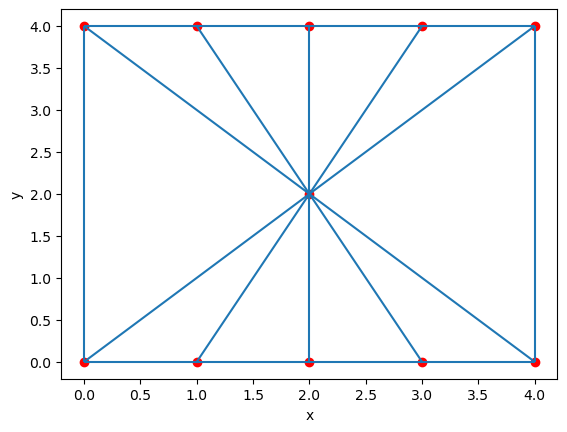

In [5]:
vertices = loadData(raw.test1_vertices, raw.test1_edges)
# visualize graph
vis = Visualizer()
points = [(n.x, n.y) for n in vertices]
segments = []
for n in vertices:
    for out in n.nodesOut:
        segments.append(((n.x, n.y), (out[0].x, out[0].y)))
vis.add_point(points, color="red")
vis.add_line_segment(segments)
vis.show()

In [6]:
calculateWeights(vertices)

## Build separators

In [7]:
class Separator:
    def __init__(self):
        self.points = []
        self.edges = []

    def addPoint(self, point: Tuple[float, float]):
        self.points.append(point)

    def addEdge(self, edge: Tuple[Tuple[float, float], Tuple[float, float]]):
        self.edges.append(edge)

In [8]:
def findSeparators(graph):
    def buildSeparator(source: Node, separator: Separator):
        point = source
        while len(point.nodesOut)!=0:
            separator.addPoint((point.x,point.y))
            out = point.nodesOut
            # find lefmost non-zero weight edge
            i = len(out) - 1
            while out[i][1] == 0:
                i -= 1
            out[i] = (out[i][0], out[i][1] - 1)
            point=out[i][0]
        # add sink
        separator.addPoint((point.x,point.y))

    # number of separators
    n = sum([w for (_, w) in graph[0].nodesOut])
    separators = [Separator() for _ in range(n)]
    for i in range(n):
        buildSeparator(graph[0], separators[i])

    # build edges
    for i in range(n):
        points = separators[i].points
        for o in range(len(points) - 1):
            separators[i].addEdge((points[o], points[o + 1]))
    return separators

In [9]:
separators = findSeparators(vertices)

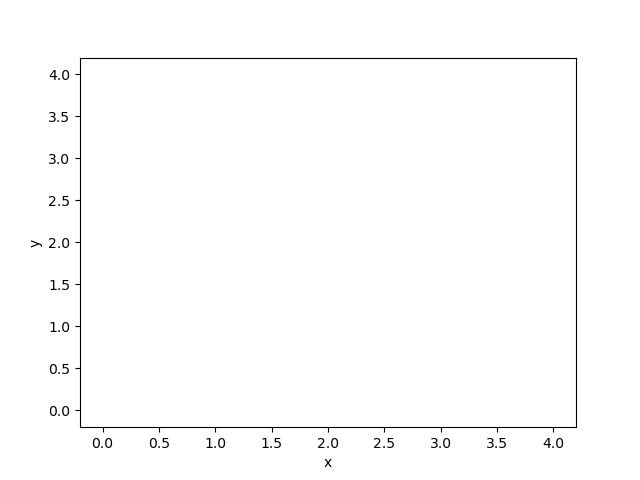

In [10]:
for separator in separators:
    to_remove = vis.add_line_segment(separator.edges, color="black")
    vis.remove_figure(to_remove)
vis.show_gif(interval=500)

## Build a BST

In [11]:
class TreeNode:
    def __init__(self, segments: List[Tuple[Tuple[float, float], Tuple[float, float]]],separator:Separator,parent):
        self.right  = None
        self.left = None
        self.parent=parent
        self.segments = segments
        self.separator=separator

In [12]:
def arrayToBST(array: List, parent:TreeNode) -> TreeNode:
    if not array:
        return None
    # build root
    mid = len(array) // 2
    newEdges = []
    for edge in array[mid].edges:
        # odcinki w edges zawsze sa posortowane ? (a,b) -> a<=b (chyba tak), jezeli nie trzeba sprawdzic dla edge=(a,b): (b,a) not in visited
        newEdges.append(edge)

    root = TreeNode(newEdges,array[mid],parent)
    root.left = arrayToBST(array[:mid],root)
    root.right = arrayToBST(array[mid + 1 :],root)

    return root

In [13]:
def printTree(node, level=0):
    if node != None:
        printTree(node.left, level + 1)
        print(' ' * 4 * level + '-> ' + str(len(node.segments)))
        printTree(node.right, level + 1)

In [14]:
def location(point :Tuple[float,float], root :TreeNode,prev :TreeNode):
    if root == None:
        return prev.separator
    x, y=point
    wspolliniowy=()
    for p1, p2 in root.segments:
        if p1[1]<=y<p2[1] or p1[1]==y==p2[1]:
            d=det(p1,p2,point)
            if d<0: # prawa strona
                return location(point,root.right,root)
            elif d>0:
                return location(point,root.left,root)
            else:
                # sprawdzenie czy punkt faktycznie nalezy do odcinka
                if p1[0] > p2[0]: p1,p2=p2,p1
                wspolliniowy=(p1,p2)
                if p1[0]<=x<=p2[0]:
                    return (p1,p2)
    if x>wspolliniowy[1][0]: return location(point,root.right,root)
    else: return location(point,root.left,root)

In [15]:
def second_separator(s :Separator,separators,point):
    idx=separators.index(s)
    _, y=point
    for p1,p2 in s.edges:
        if p1[1]<=y<=p2[1]:
            d=det(p1,p2,point)
            if d<0: # prawa strona
                return separators[idx+1]
            elif d>0:
                return separators[idx-1]

In [16]:
def exact_area_edges(sep1,sep2,point):
    n1,n2=len(sep1),len(sep2)
    i=0
    j=0
    edges=[]
    while i<n1 and j<n2:
        if sep1[i]==sep2[j]:
            i+=1
            j+=1
        else:
            while  i<n1 and j<n2:
                if sep1[i][1]==sep2[j][1]:
                    edges.append(sep1[i])
                    edges.append(sep2[j])
                    i+=1
                    j+=1
                    if edges[-1][1][1]>point[1]:
                        return edges
                    else:
                      edges=[]
                      break
                if sep1[i][1][1]<sep2[j][1][1]:
                    edges.append(sep1[i])
                    i+=1
                elif sep1[i][1][1]>sep2[j][1][1]:
                    edges.append(sep2[j])
                    j+=1
                else:
                    if j<n2-1 and sep1[i][1]==sep2[j+1][1]:
                        edges.append(sep2[j])
                        j+=1
                    elif i < n1-1 and sep2[j][1]==sep1[i+1][1]:
                        edges.append(sep1[i])
                        i+=1
                    else:
                        edges.append(sep1[i])
                        edges.append(sep2[j])
                        i+=1
                        j+=1

In [17]:
def on_second(sep,point):
    x,y=point
    for p1, p2 in sep.edges:
        if p1[1]<=y<=p2[1]:
            d=det(p1,p2,point)
            if d==0:
                # sprawdzenie czy punkt faktycznie nalezy do odcinka
                if p1[0] > p2[0]: p1,p2=p2,p1
                if p1[0]<=x<=p2[0]:
                    return (p1,p2)
    return ()

In [18]:
def separators_method_point_location_algorithm(raw_vertices,raw_edges,point):
    
    v=loadData(raw_vertices,raw_edges)
    calculateWeights(v)
    separators=findSeparators(v)
    
    r = arrayToBST(separators,None)
    sepl=location(point,r,None)
    
    if isinstance(sepl,Separator):
        sepr=second_separator(sepl,separators,point)
        xd=on_second(sepr,point)
        if xd != (): return xd
    else:
        return sepl
    
    return exact_area_edges(sepl.edges,sepr.edges,point)

In [19]:
def separators_method_point_location_algorithm_visualiser(raw_vertices,raw_edges,point):
    vertices = loadData(raw_vertices, raw_edges)

    # visualize graph
    vis = Visualizer()
    points = [(n.x, n.y) for n in vertices]
    segments = []
    for n in vertices:
        for out in n.nodesOut:
            segments.append(((n.x, n.y), (out[0].x, out[0].y)))
    edges=separators_method_point_location_algorithm(raw_vertices, raw_edges,point)
    vis.add_point(points, color="red")
    vis.add_point(point, color="green")
    vis.add_line_segment(segments)
    vis.add_line_segment(edges,color='red')
    return vis,edges

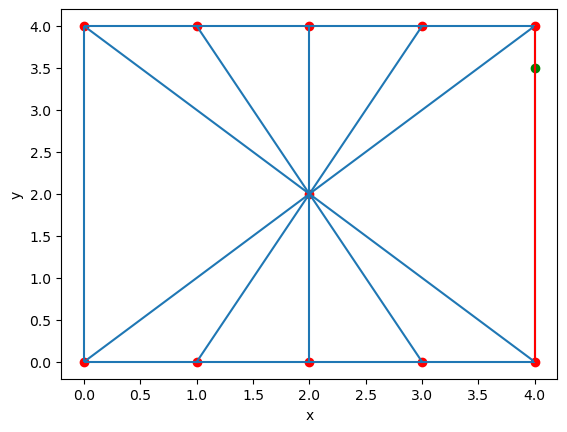

In [23]:
point1=(4,3.5)
vis1,e=separators_method_point_location_algorithm_visualiser(raw.test1_vertices, raw.test1_edges,point1)
vis1.show()

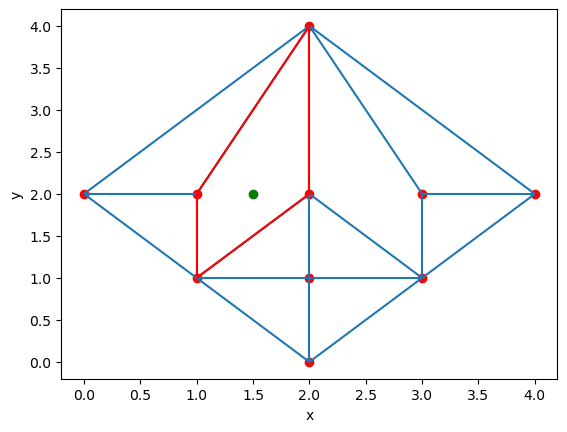

In [21]:
point2=(1.5,2)
vis2,edges=separators_method_point_location_algorithm_visualiser(raw.test2_vertices, raw.test2_edges,point2)
vis2.show()

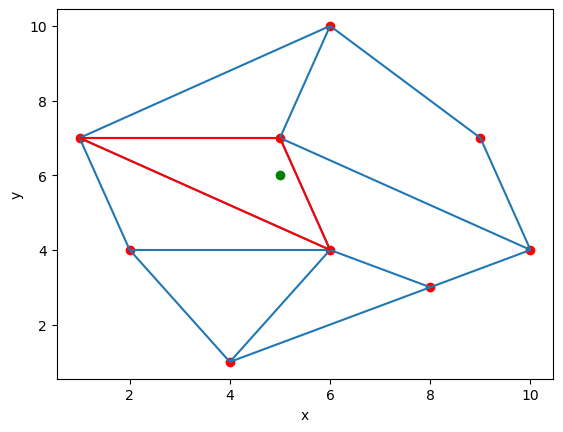

In [22]:
point3=(5,6)
vis3,e=separators_method_point_location_algorithm_visualiser(raw.vertices, raw.edges,point3)
vis3.show()

Szukany punkt: (1.5, 0.5)
Znalezione krawędzie obszaru: [((0.0, 0.0), (2.0, 0.0)), ((2.0, 0.0), (2.0, 2.0)), ((0.0, 0.0), (2.0, 2.0))]


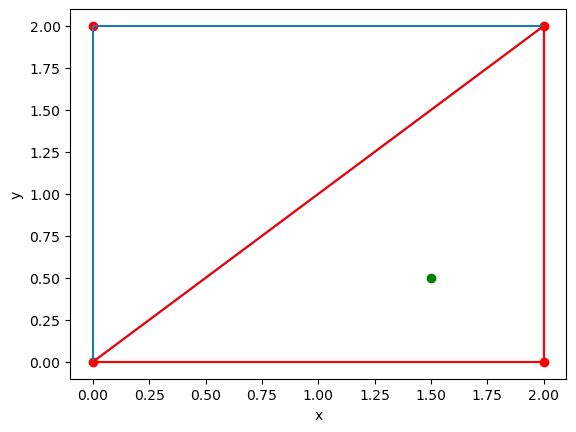

In [28]:
# 1. Definicja danych testowych (zgodna z setUp w testach)
# Wierzchołki: (0,0), (2,0), (2,2), (0,2)
test_vertices = [(0.0, 0.0), (2.0, 0.0), (2.0, 2.0), (0.0, 2.0)]

# Krawędzie: Obwód + przekątna (0,2)
test_edges = [
    (0, 1), # dół
    (1, 2), # prawa
    (2, 3), # góra
    (3, 0), # lewa
    (0, 2)  # przekątna
]

# 2. Punkt testowy (wewnątrz dolnego trójkąta)
point_bottom = (1.5, 0.5)

# 3. Uruchomienie Twojej funkcji wizualizującej
vis_test1, found_edges1 = separators_method_point_location_algorithm_visualiser(
    test_vertices, 
    test_edges, 
    point_bottom
)

print(f"Szukany punkt: {point_bottom}")
print(f"Znalezione krawędzie obszaru: {found_edges1}")

# 4. Wyświetlenie
vis_test1.show()

Szukany punkt: (0.5, 1.5)
Znalezione krawędzie obszaru: [((0.0, 0.0), (2.0, 2.0)), ((0.0, 0.0), (0.0, 2.0)), ((2.0, 2.0), (0.0, 2.0))]


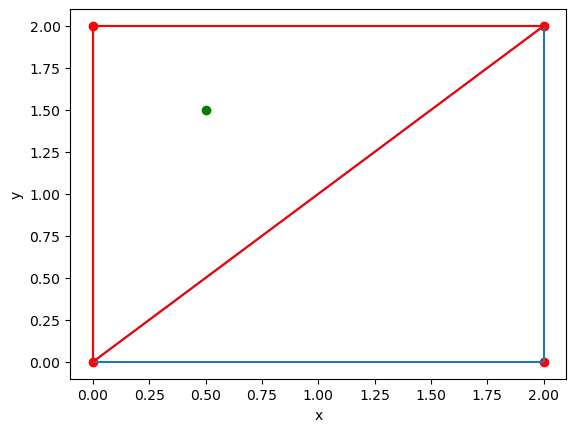

In [30]:
# Punkt testowy (wewnątrz górnego trójkąta)
point_top = (0.5, 1.5)

# Uruchomienie wizualizacji
vis_test2, found_edges2 = separators_method_point_location_algorithm_visualiser(
    test_vertices, 
    test_edges, 
    point_top
)

print(f"Szukany punkt: {point_top}")
print(f"Znalezione krawędzie obszaru: {found_edges2}")

vis_test2.show()

Wygenerowano graf: 12 wierzchołków, 23 krawędzi.

--- Test 1: Wewnątrz trójkąta (dolny) (0.7, 0.2) ---
Zwrócone krawędzie obszaru: [((0.0, 0.0), (1.0, 0.0)), ((0.0, 0.0), (1.0, 1.0)), ((1.0, 0.0), (1.0, 1.0))]

--- Test 2: Wewnątrz trójkąta (górny) (1.2, 1.8) ---
Zwrócone krawędzie obszaru: [((1.0, 1.0), (1.0, 2.0)), ((1.0, 1.0), (2.0, 2.0)), ((1.0, 2.0), (2.0, 2.0))]

--- Test 3: Na krawędzi (przekątna) (0.5, 0.5) ---
Zwrócone krawędzie obszaru: ((0.0, 0.0), (1.0, 1.0))

--- Test 4: Na wierzchołku (1.0, 1.0) ---
Zwrócone krawędzie obszaru: ((1.0, 1.0), (2.0, 1.0))


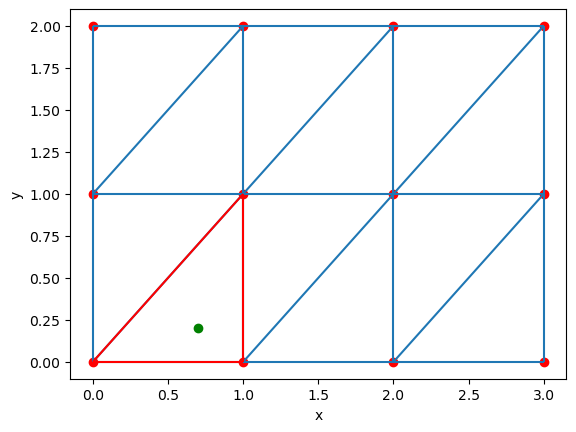

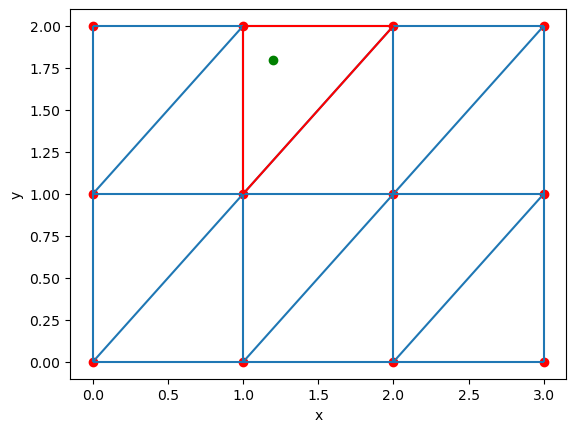

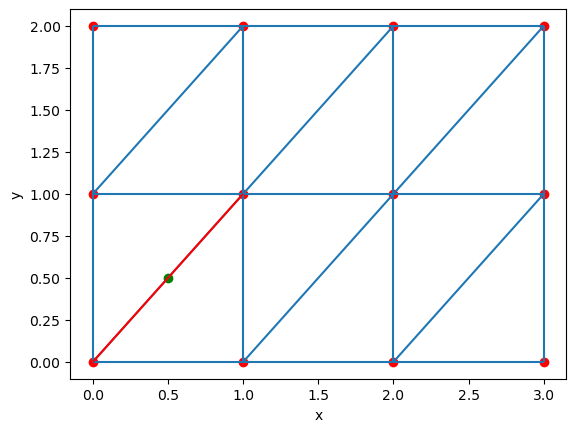

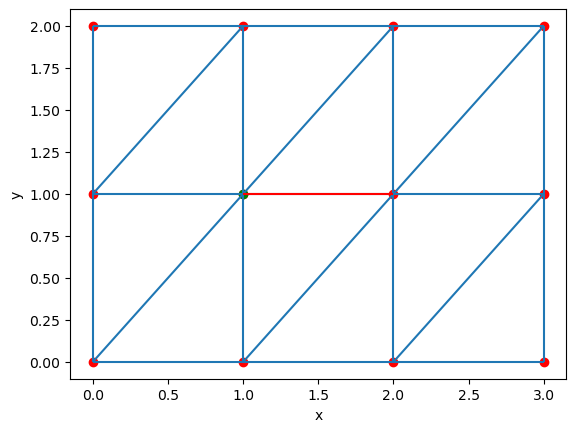

In [31]:
import matplotlib.pyplot as plt

def generate_grid_graph(width, height):
    """
    Generuje wierzchołki i krawędzie dla siatki o wymiarach width x height.
    Każdy kwadrat siatki jest dzielony przekątną (z lewego-dołu do prawego-góry).
    """
    vertices = []
    edges = []
    
    # Generowanie wierzchołków
    # y - rzędy, x - kolumny
    for y in range(height + 1):
        for x in range(width + 1):
            vertices.append((float(x), float(y)))

    # Funkcja pomocnicza do pobierania indeksu wierzchołka (x, y)
    def get_idx(x, y):
        return y * (width + 1) + x

    # Generowanie krawędzi
    for y in range(height):
        for x in range(width):
            u = get_idx(x, y)           # (x, y)
            right = get_idx(x + 1, y)   # (x+1, y)
            top = get_idx(x, y + 1)     # (x, y+1)
            top_right = get_idx(x + 1, y + 1) # (x+1, y+1)

            # Krawędzie zewnętrzne i wewnętrzne
            # Dodajemy krawędź "w prawo" (jeśli to nie ostatnia kolumna - handled by loop range)
            edges.append((u, right))
            # Dodajemy krawędź "w górę"
            edges.append((u, top))
            # Dodajemy krawędź "w górę" dla prawego sąsiada (domykamy prawą ścianę w ostatniej pętli x)
            edges.append((right, top_right))
            # Dodajemy krawędź "w prawo" dla górnego sąsiada (domykamy górną ścianę)
            edges.append((top, top_right))
            
            # Przekątna (z dołu-lewo do góry-prawo)
            edges.append((u, top_right))

    # Usuwanie duplikatów krawędzi (set krotek posortowanych)
    unique_edges = set()
    for u, v in edges:
        if u < v:
            unique_edges.add((u, v))
        else:
            unique_edges.add((v, u))
            
    return vertices, list(unique_edges)

# 1. Generowanie danych: Siatka 3x2 (12 trójkątów)
# Wymiary: x w [0, 3], y w [0, 2]
grid_vertices, grid_edges = generate_grid_graph(3, 2)

print(f"Wygenerowano graf: {len(grid_vertices)} wierzchołków, {len(grid_edges)} krawędzi.")

# 2. Definicja punktów testowych
test_points = [
    # A. Wewnątrz trójkąta (dolny-lewy róg, pod przekątną)
    # Kwadrat (0,0)-(1,1), pod y=x
    {"point": (0.7, 0.2), "desc": "Wewnątrz trójkąta (dolny)"},
    
    # B. Wewnątrz trójkąta (górny rząd, nad przekątną)
    # Kwadrat (1,1)-(2,2), nad przekątną
    {"point": (1.2, 1.8), "desc": "Wewnątrz trójkąta (górny)"},
    
    # C. Na krawędzi (przekątnej pierwszego kwadratu)
    {"point": (0.5, 0.5), "desc": "Na krawędzi (przekątna)"},
    
    # D. Na wierzchołku (środek siatki)
    {"point": (1.0, 1.0), "desc": "Na wierzchołku"}
]

# 3. Uruchomienie wizualizacji dla każdego punktu
for i, case in enumerate(test_points):
    p = case["point"]
    desc = case["desc"]
    
    print(f"\n--- Test {i+1}: {desc} {p} ---")
    try:
        # Wywołanie Twojej funkcji wizualizującej
        # Uwaga: Zakładam, że funkcja zwraca obiekt Visualizer
        vis_obj, found_edges = separators_method_point_location_algorithm_visualiser(
            grid_vertices, 
            grid_edges, 
            p
        )
        print(f"Zwrócone krawędzie obszaru: {found_edges}")
        
        # Wyświetlenie
        # W Jupyterze każde .show() wygeneruje oddzielny obrazek
        vis_obj.show()
    except Exception as e:
        print(f"Błąd podczas testu {i+1}: {e}")


SCENARIUSZ 1: Siatka 3x3 (18 trójkątów)
  -> Punkt 01: (2.77, 2.62)
  -> Punkt 02: (0.98, 2.40)
  -> Punkt 03: (2.78, 0.14)
  -> Punkt 04: (2.54, 0.11)
  -> Punkt 05: (2.17, 0.29)
  -> Punkt 06: (1.54, 2.98)
  -> Punkt 07: (2.43, 2.66)
  -> Punkt 08: (0.38, 2.13)
  -> Punkt 09: (2.85, 2.50)
  -> Punkt 10: (2.03, 1.52)

SCENARIUSZ 2: Siatka 4x2 (16 trójkątów)
  -> Punkt 01: (1.16, 1.72)
  -> Punkt 02: (0.48, 0.11)
  -> Punkt 03: (1.48, 0.59)
  -> Punkt 04: (3.29, 1.99)
  -> Punkt 05: (2.23, 0.33)
  -> Punkt 06: (3.27, 1.10)
  -> Punkt 07: (1.09, 0.52)
  -> Punkt 08: (3.96, 1.30)
  -> Punkt 09: (2.63, 0.43)
  -> Punkt 10: (3.98, 1.73)

SCENARIUSZ 3: Siatka 2x5 (20 trójkątów)
  -> Punkt 01: (0.50, 1.84)
  -> Punkt 02: (0.44, 2.53)
  -> Punkt 03: (1.85, 3.74)


c:\Geometric-Algorithms-Project\bitalg\visualizer\plot\plot.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


  -> Punkt 04: (0.77, 1.04)
  -> Punkt 05: (0.32, 2.20)
  -> Punkt 06: (0.23, 3.88)
  -> Punkt 07: (1.34, 2.66)
  -> Punkt 08: (0.95, 1.56)
  -> Punkt 09: (0.30, 0.92)
  -> Punkt 10: (1.93, 4.22)

SCENARIUSZ 4: Siatka 5x5 (50 trójkątów)
  -> Punkt 01: (3.28, 2.08)
  -> Punkt 02: (0.60, 0.45)
  -> Punkt 03: (2.11, 1.32)
  -> Punkt 04: (4.46, 0.17)
  -> Punkt 05: (4.85, 3.35)
  -> Punkt 06: (2.08, 2.30)
  -> Punkt 07: (3.92, 2.43)
  -> Punkt 08: (1.59, 0.74)
  -> Punkt 09: (4.72, 3.40)
  -> Punkt 10: (2.92, 0.33)

SCENARIUSZ 5: Siatka 6x4 (48 trójkątów)
  -> Punkt 01: (5.35, 0.25)
  -> Punkt 02: (1.94, 3.10)
  -> Punkt 03: (1.80, 2.75)
  -> Punkt 04: (4.52, 1.61)
  -> Punkt 05: (1.72, 2.28)
  -> Punkt 06: (1.14, 3.13)
  -> Punkt 07: (2.62, 1.87)
  -> Punkt 08: (5.32, 2.51)
  -> Punkt 09: (0.65, 1.35)
  -> Punkt 10: (0.39, 0.80)


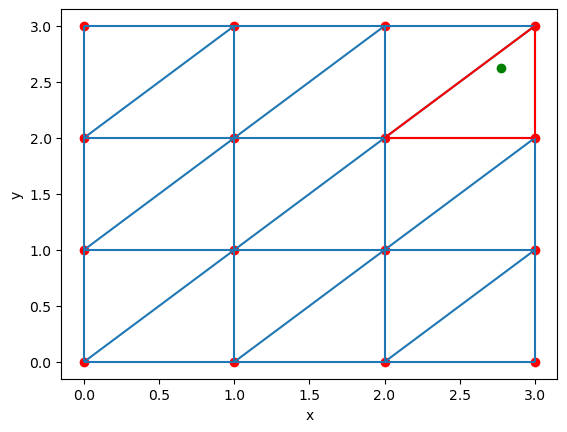

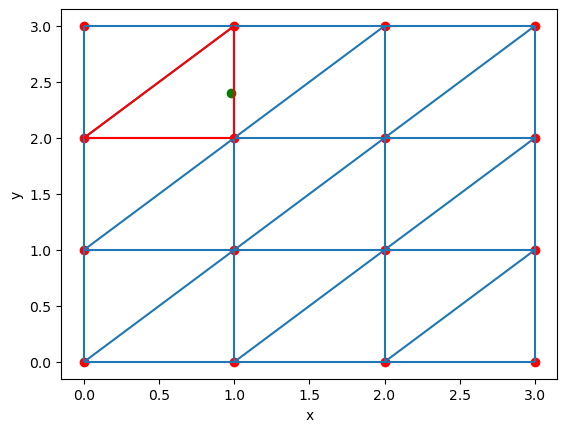

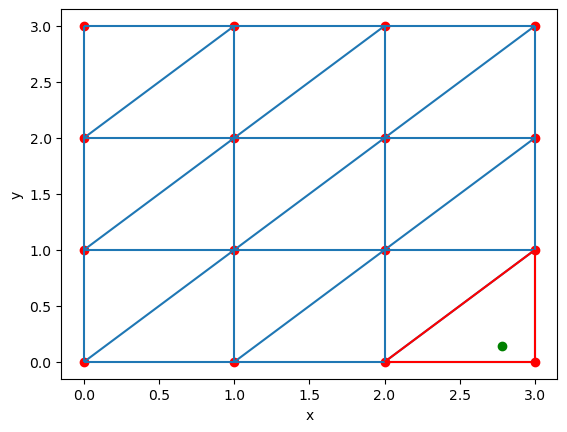

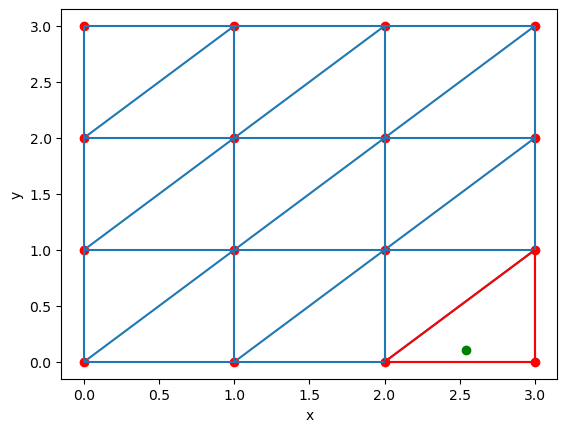

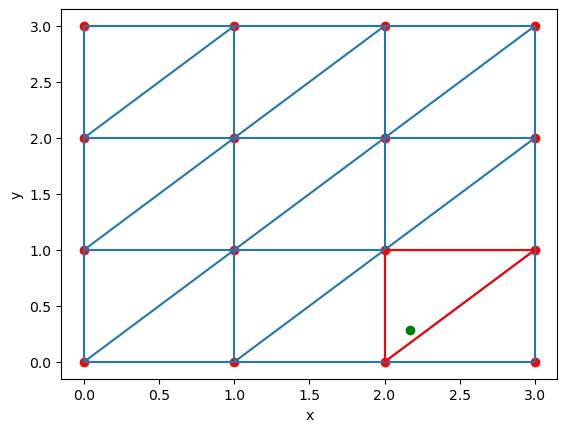

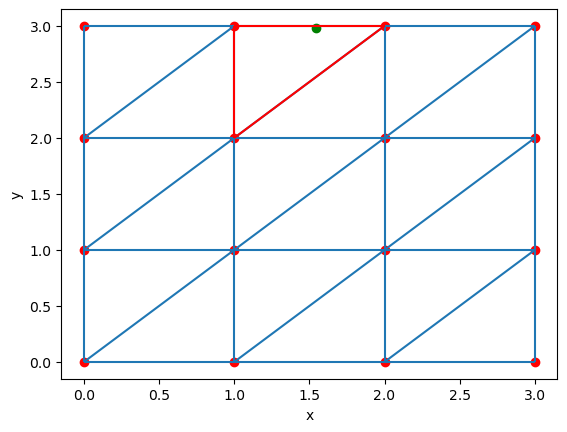

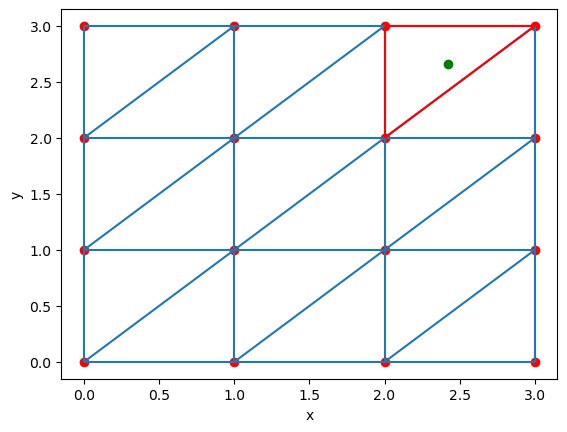

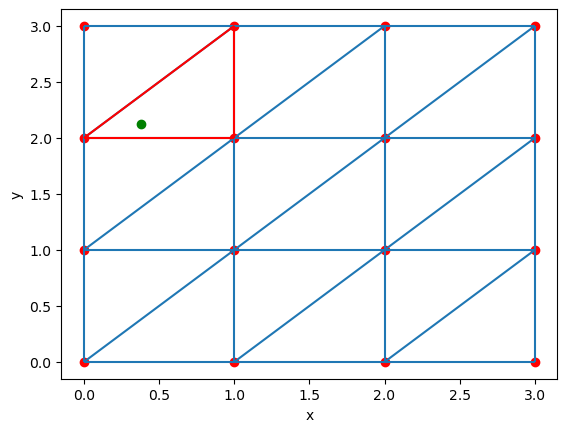

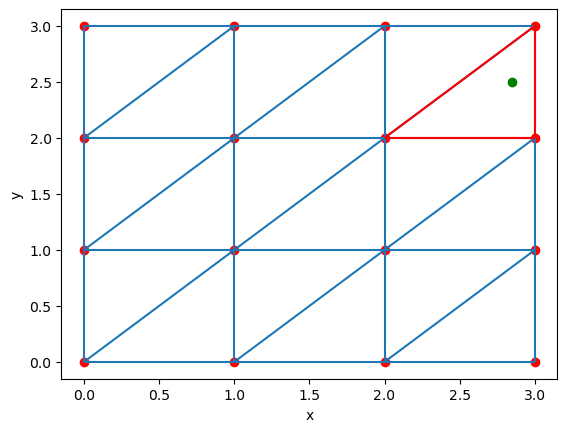

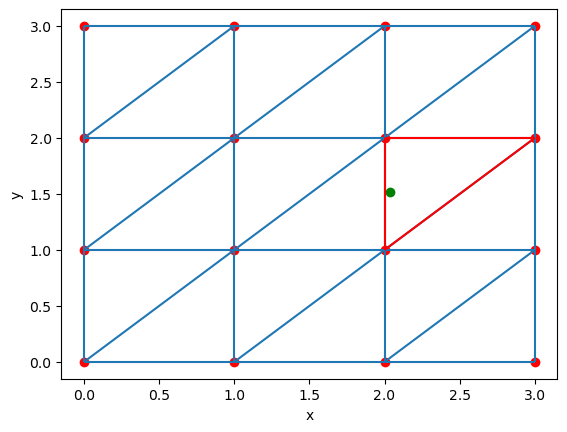

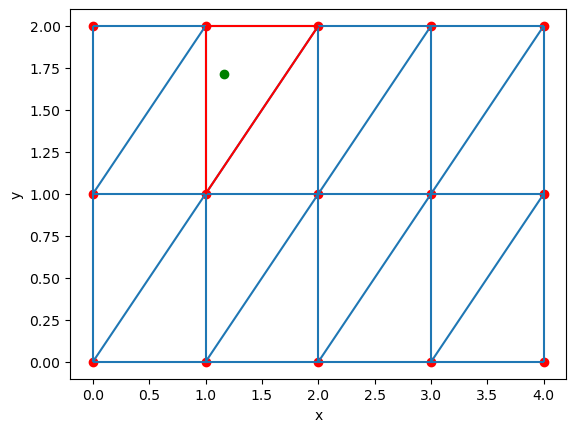

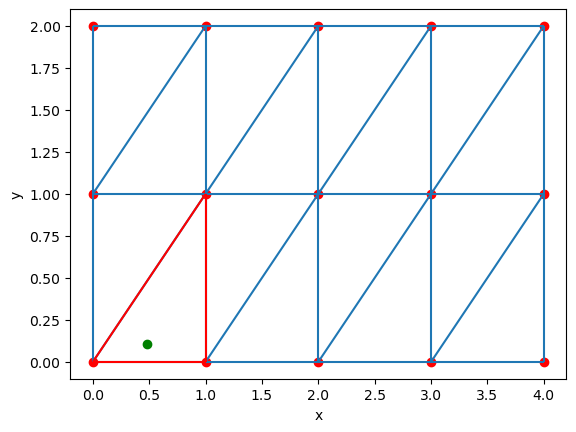

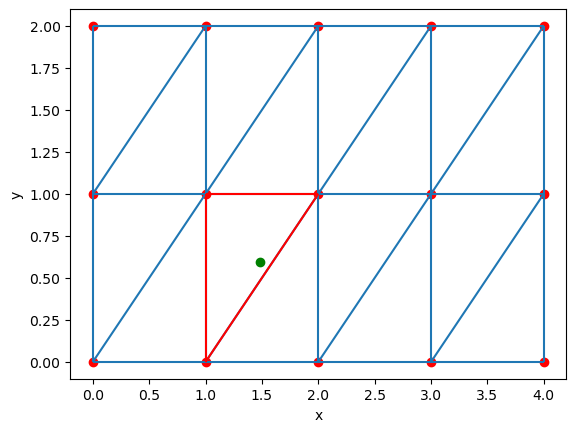

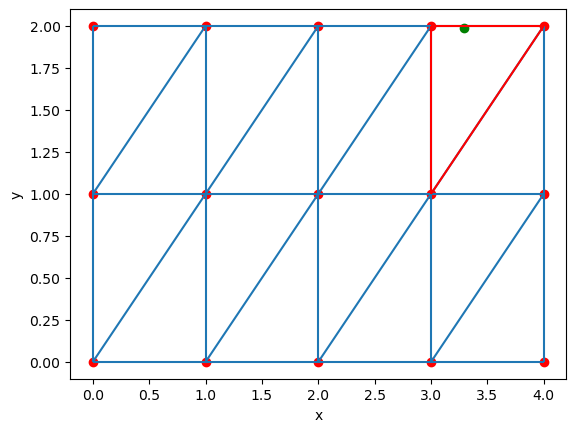

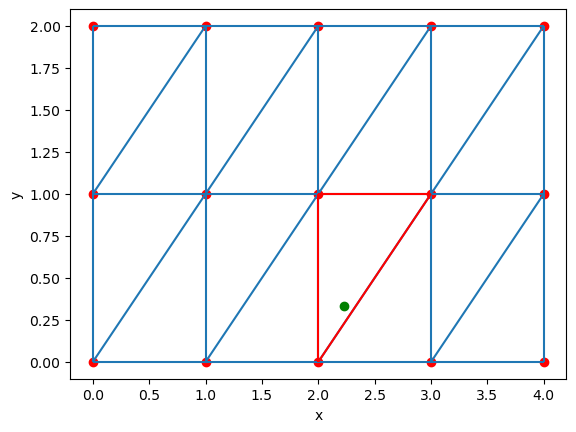

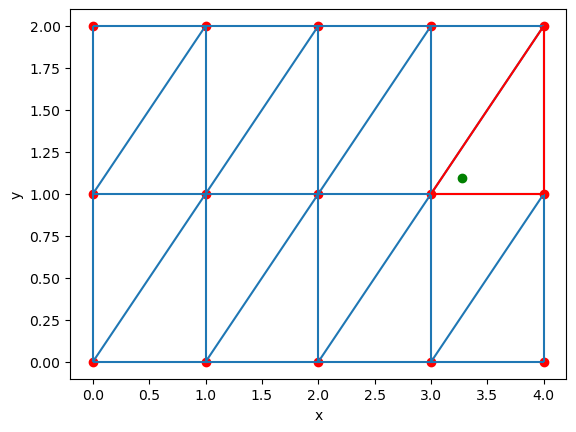

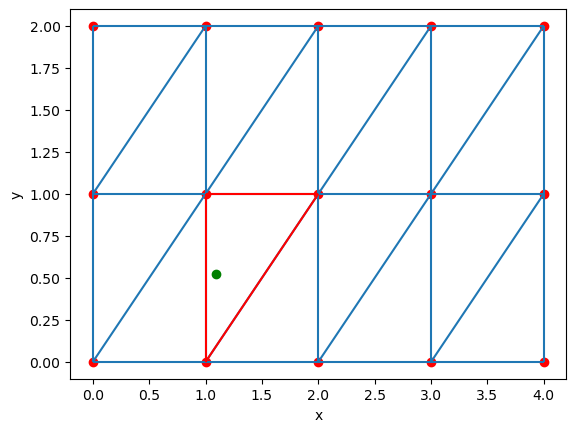

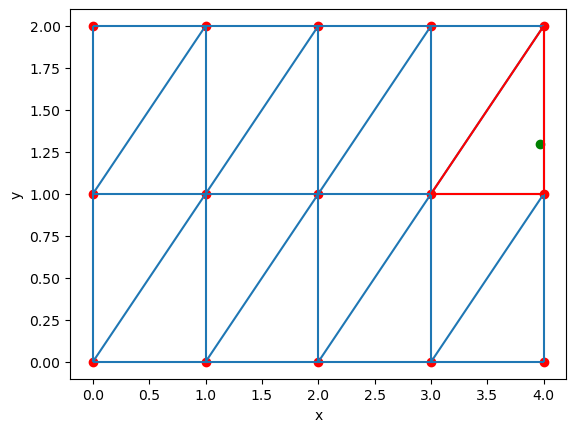

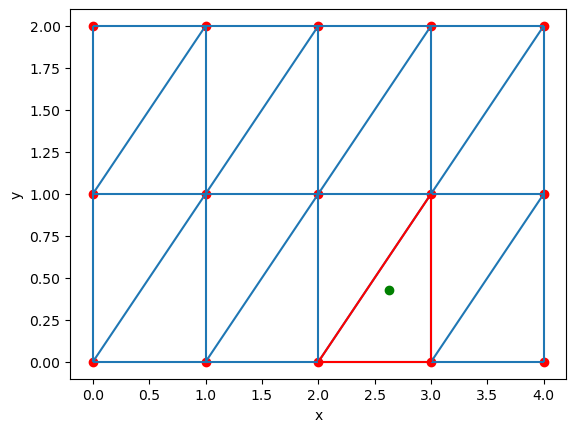

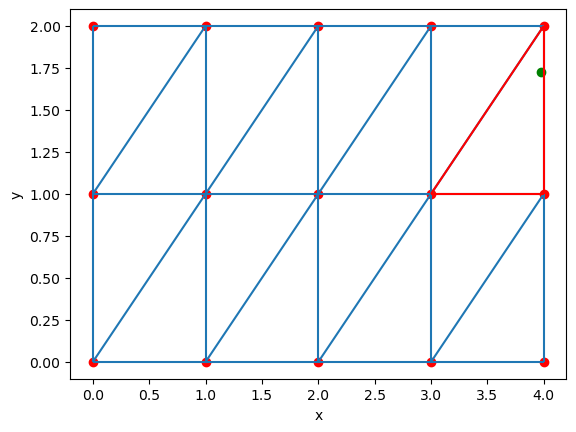

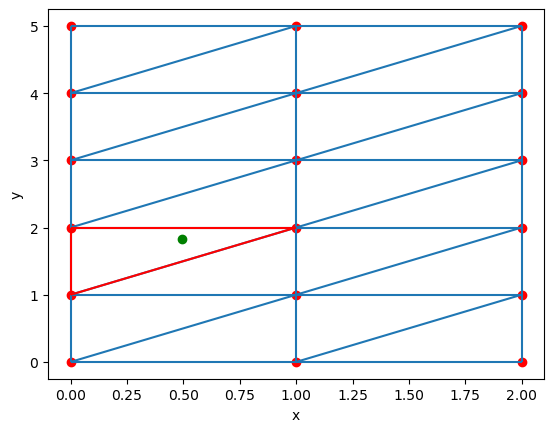

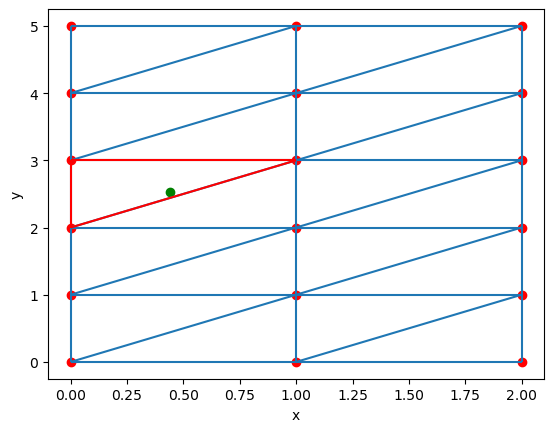

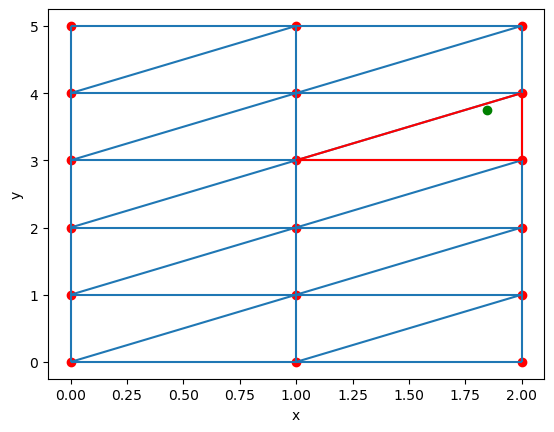

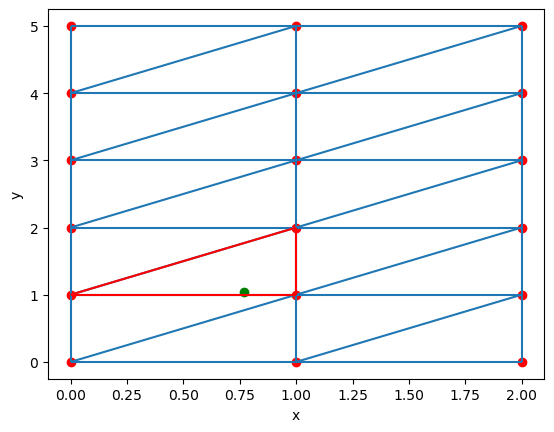

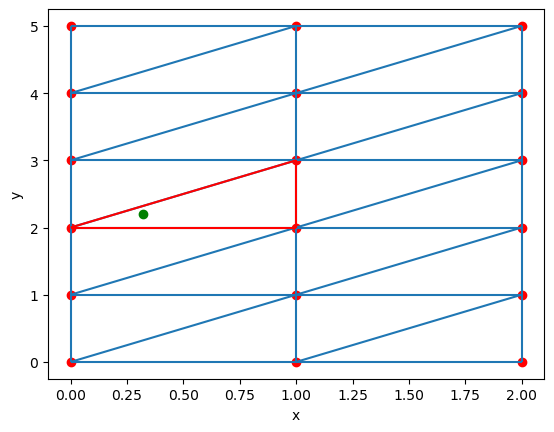

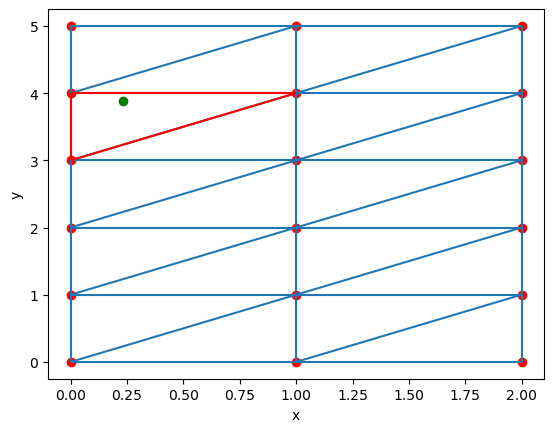

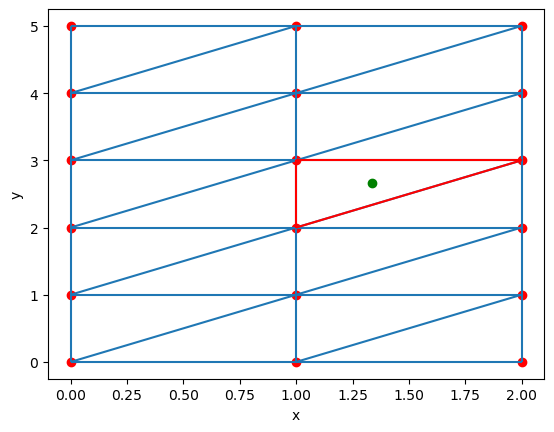

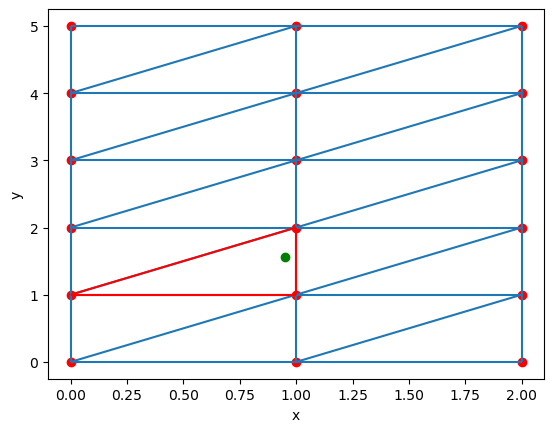

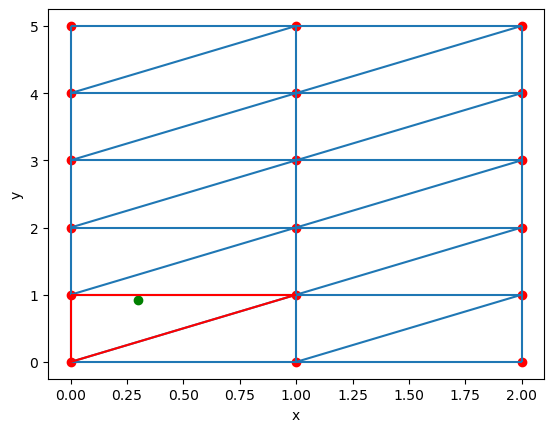

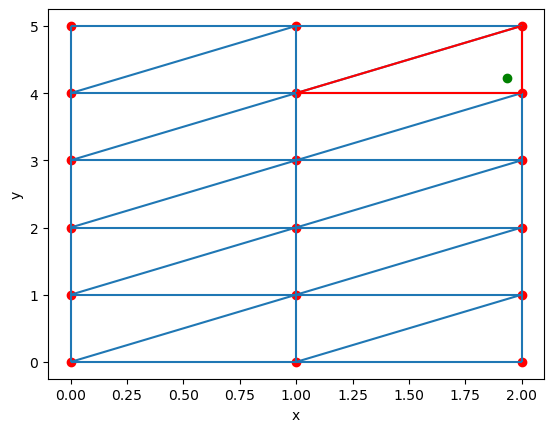

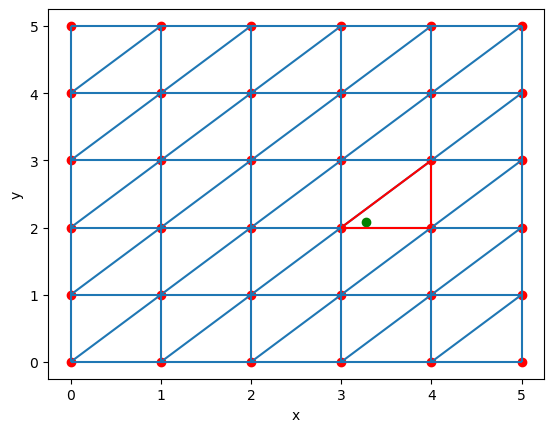

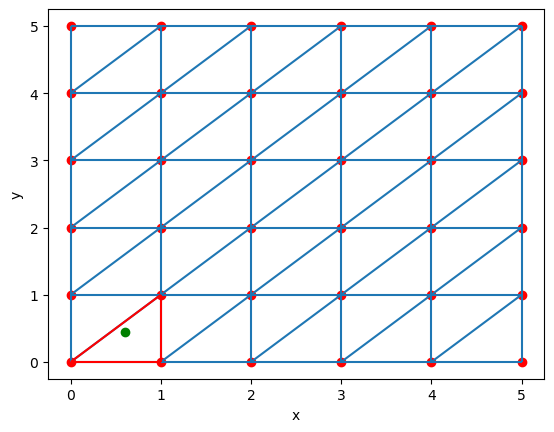

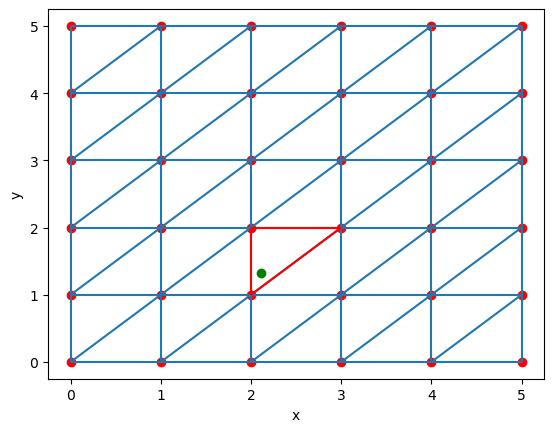

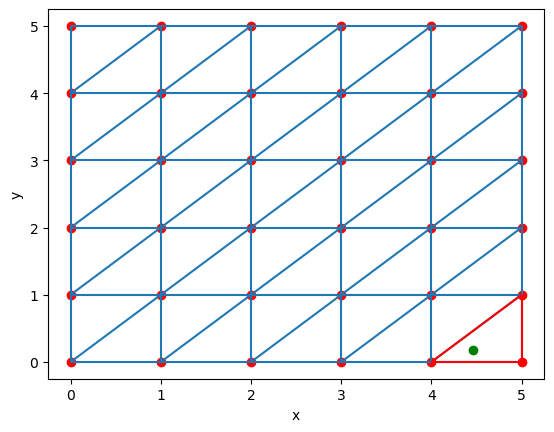

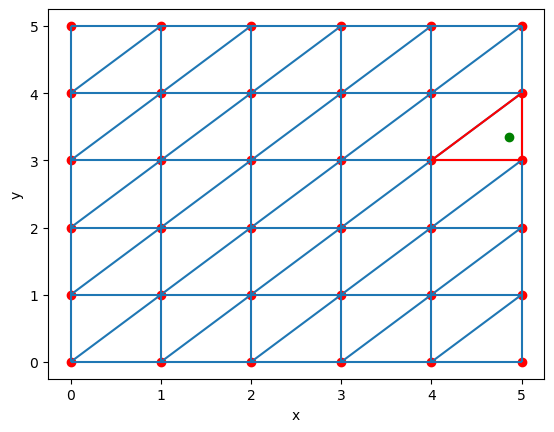

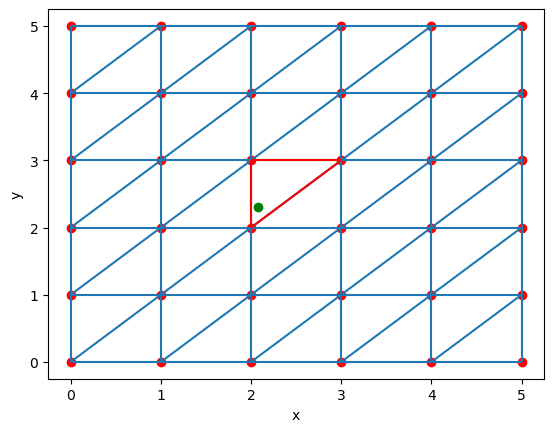

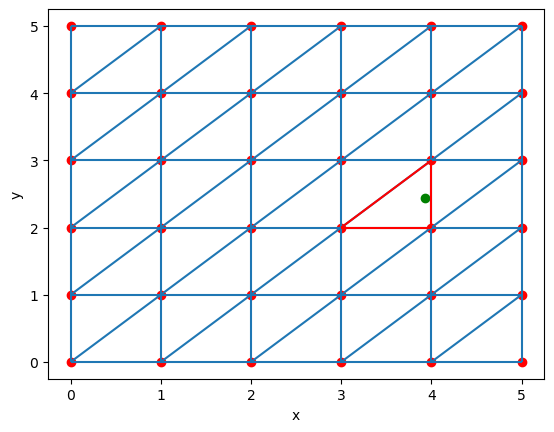

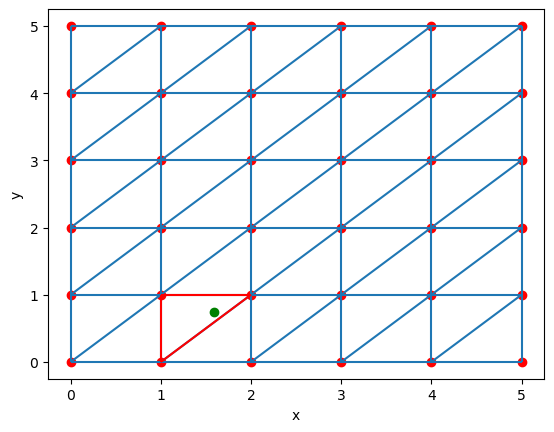

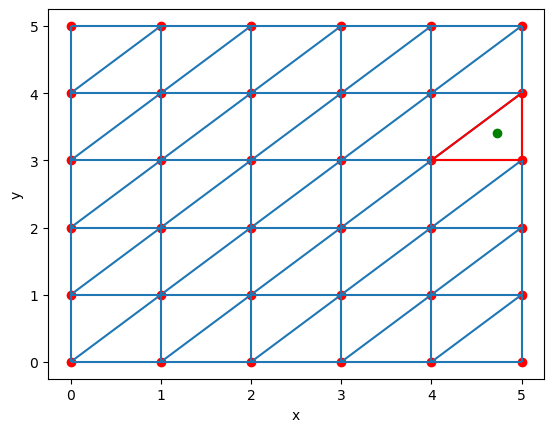

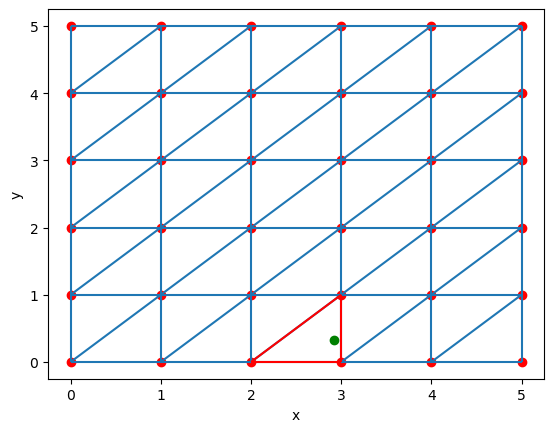

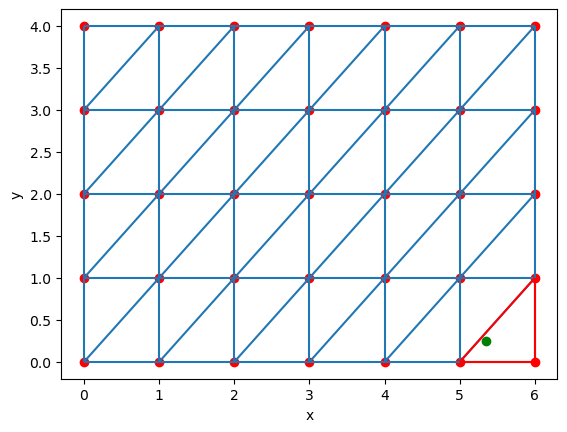

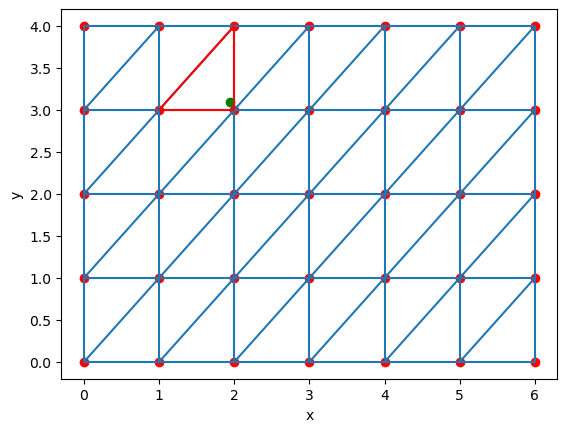

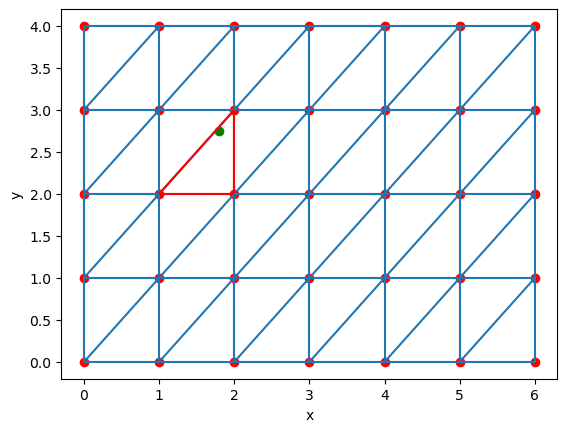

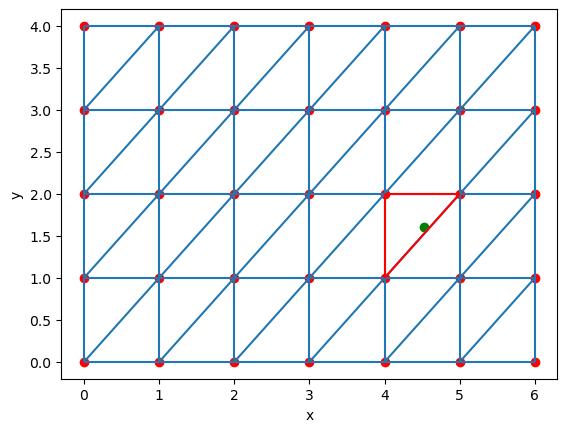

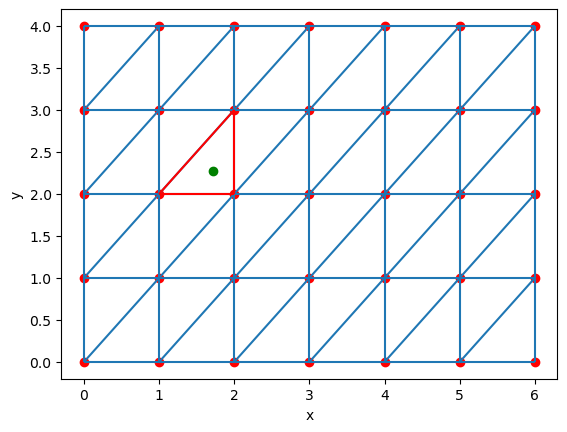

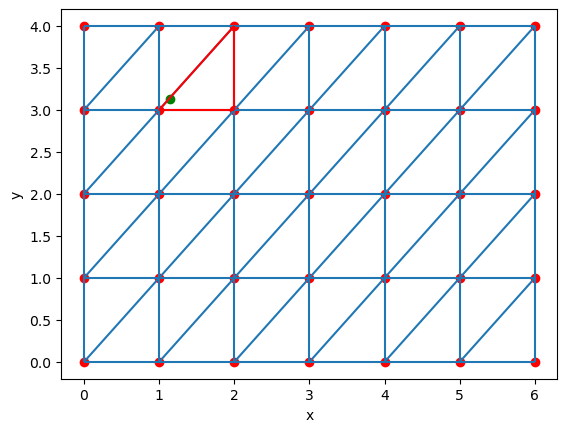

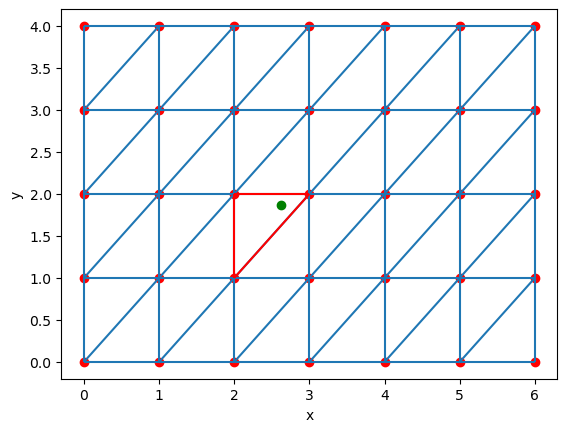

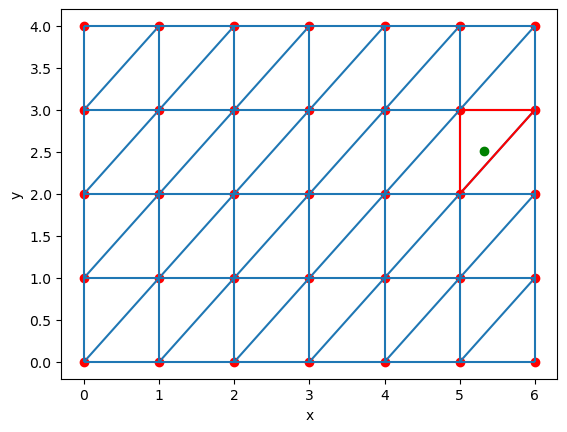

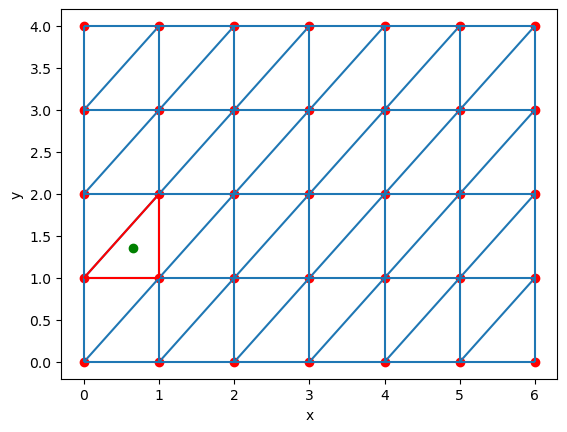

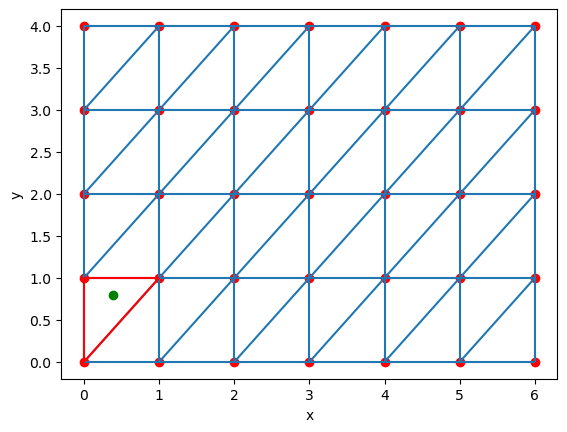

In [32]:
import random
import matplotlib.pyplot as plt

# 1. Funkcja generująca graf (siatkę)
def generate_grid_graph(width, height):
    """
    Generuje wierzchołki i krawędzie dla siatki o wymiarach width x height.
    Zwraca format zgodny z loadData: wierzchołki jako (x,y), krawędzie jako (idx1, idx2).
    """
    vertices = []
    edges = []
    
    # Generowanie wierzchołków
    for y in range(height + 1):
        for x in range(width + 1):
            vertices.append((float(x), float(y)))

    def get_idx(x, y):
        return y * (width + 1) + x

    # Generowanie krawędzi
    for y in range(height):
        for x in range(width):
            u = get_idx(x, y)
            right = get_idx(x + 1, y)
            top = get_idx(x, y + 1)
            top_right = get_idx(x + 1, y + 1)

            edges.append((u, right))
            edges.append((u, top))
            edges.append((right, top_right))
            edges.append((top, top_right))
            edges.append((u, top_right)) # Przekątna

    # Usuwanie duplikatów krawędzi
    unique_edges = set()
    for u, v in edges:
        if u < v: unique_edges.add((u, v))
        else: unique_edges.add((v, u))
            
    return vertices, list(unique_edges)

# 2. Definicja 5 scenariuszy (wymiary siatek)
scenarios = [
    {"dim": (3, 3), "desc": "Siatka 3x3 (18 trójkątów)"},
    {"dim": (4, 2), "desc": "Siatka 4x2 (16 trójkątów)"},
    {"dim": (2, 5), "desc": "Siatka 2x5 (20 trójkątów)"},
    {"dim": (5, 5), "desc": "Siatka 5x5 (50 trójkątów)"},
    {"dim": (6, 4), "desc": "Siatka 6x4 (48 trójkątów)"}
]

# 3. Pętla testowa
for s_idx, scen in enumerate(scenarios):
    w, h = scen["dim"]
    desc = scen["desc"]
    
    print(f"\n{'='*60}")
    print(f"SCENARIUSZ {s_idx + 1}: {desc}")
    print(f"{'='*60}")
    
    # Generowanie grafu
    vertices, edges = generate_grid_graph(w, h)
    
    # Generowanie 10 losowych punktów wewnątrz obszaru siatki
    points_to_check = []
    for _ in range(10):
        # Losujemy floaty w zakresie (0, width) i (0, height)
        px = random.uniform(0, w)
        py = random.uniform(0, h)
        points_to_check.append((px, py))
        
    # Uruchomienie testów dla punktów
    for p_idx, point in enumerate(points_to_check):
        print(f"  -> Punkt {p_idx + 1:02d}: ({point[0]:.2f}, {point[1]:.2f})")
        
        try:
            # Uruchomienie Twojego algorytmu wizualizującego
            vis_obj, found_edges = separators_method_point_location_algorithm_visualiser(
                vertices, 
                edges, 
                point
            )
            
            # Wypisanie znalezionych krawędzi (opcjonalne, dla weryfikacji)
            # print(f"     Znaleziono obszar ograniczony przez: {found_edges}")
            
            # Wyświetlenie wizualizacji
            vis_obj.show()
            
        except Exception as e:
            print(f"     [BŁĄD] Nie udało się zlokalizować punktu: {e}")